<a href="https://colab.research.google.com/github/AlexBoving/survival-analysis-lung-cancer/blob/main/gradient_boosted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install scikit-survival

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 8.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


# Gradient Boosted Models

Gradient Boosting does not refer to one particular model, but a versatile framework to optimize many loss functions. It follows the strength in numbers principle by combining the predictions of multiple base learners to obtain a powerful overall model. The base learners are often very simple models that are only slightly better than random guessing, which is why they are also referred to as weak learners. The predictions are combined in an additive manner, where the addition of each base model improves (or "boosts") the overall model. Therefore, the overall model
 is an additive model of the form:


\begin{equation}
f(\mathbf{x})=\sum_{m=1}^M \beta_m g\left(\mathbf{x} ; \theta_m\right)
\end{equation}

where M > 0 denotes the number of base learners, and $β_{m}$ is a weighting term. The function g refers to a base learner and is parameterized by the vector Θ. Individual base learners differ in the configuration of their parameters Θ, which is indicated by a subscript m.

A gradient boosted model is similar to a Random Survival Forest, in the sense that it relies on multiple base learners to produce an overall prediction, but differs in how those are combined. While a Random Survival Forest fits a set of Survival Trees independently and then averages their predictions, a gradient boosted model is constructed sequentially in a greedy stagewise fashion.

## Base learners

Depending on the loss function to be minimized and base learner used, different model arise. sksurv.ensemble.GradientBoostingSurvivalAnalysis implements gradient boosting with regression tree base learner. The former is very versatile and can account for complicated non-linear relationships between features and time to survival.

## Losses

### Cox's Partial Likelihood

The loss function can be specified via the loss argument loss; Therefore, the objective is to maximize the log partial likelihood function, but replacing the traditional linear model with the additive model.

\begin{equation}
\arg \min _f \sum_{i=1}^n \delta_i\left[f\left(\mathbf{x}_i\right)-\log \left(\sum_{j \in \mathcal{R}_i} \exp \left(f\left(\mathbf{x}_j\right)\right)\right)\right] .
\end{equation}

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

%matplotlib inline

from sksurv.datasets import load_breast_cancer
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis, GradientBoostingSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

In [3]:
# We use the breast cancer data, containing 76 genes, age, estrogen.

In [4]:
X, y = load_breast_cancer()
Xt = OneHotEncoder().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.25, random_state=0)

In [5]:
est_cph_tree = GradientBoostingSurvivalAnalysis(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
est_cph_tree.fit(X_train, y_train)
cindex = est_cph_tree.score(X_test, y_test)
print(round(cindex, 3))

0.756


This model achieves a concordance index of 0.756 on the test data. Let's see how the test performance changes with the ensemble size (n_estimators).

In [6]:
scores_cph_tree = {}

est_cph_tree = GradientBoostingSurvivalAnalysis(learning_rate=1.0, max_depth=1, random_state=0)
for i in range(1, 31):
    n_estimators = i * 5
    est_cph_tree.set_params(n_estimators=n_estimators)
    est_cph_tree.fit(X_train, y_train)
    scores_cph_tree[n_estimators] = est_cph_tree.score(X_test, y_test)

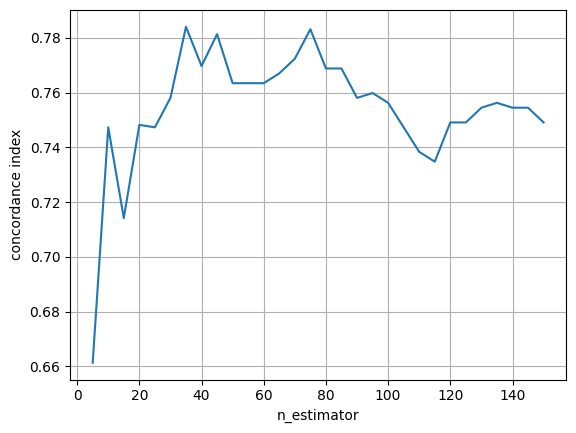

In [7]:
x, y = zip(*scores_cph_tree.items())
plt.plot(x, y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(True)

We can see that the performance quickly improves, but also that the performance starts to decrease if the ensemble becomes too big.

Let's repeat the analysis using component-wise least squares base learners.

In [8]:
scores_cph_ls = {}

est_cph_ls = ComponentwiseGradientBoostingSurvivalAnalysis(learning_rate=1.0, random_state=0)
for i in range(1, 31):
    n_estimators = i * 10
    est_cph_ls.set_params(n_estimators=n_estimators)
    est_cph_ls.fit(X_train, y_train)
    scores_cph_ls[n_estimators] = est_cph_ls.score(X_test, y_test)

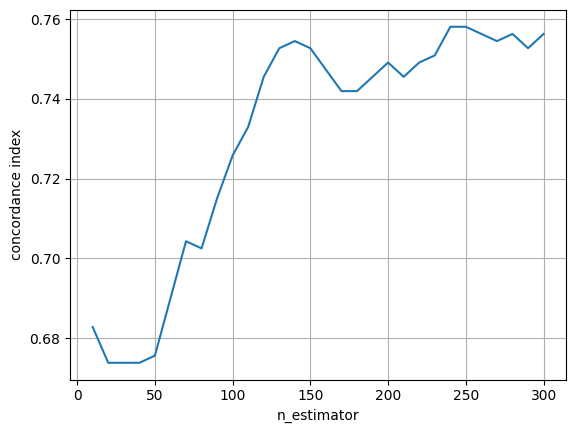

In [9]:
x, y = zip(*scores_cph_ls.items())
plt.plot(x, y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(True)

The performance increase is much slower here and its maximum performance seems to be below that of the ensemble of tree-based learners. This is not surprising, because with component-wise least squares base learners the overall ensemble is a linear model, whereas with tree-based learners it will be a non-linear model.

The coefficients of the model can be retrieved as follows:

In [10]:
coef = pd.Series(est_cph_ls.coef_, ["Intercept"] + Xt.columns.tolist())

print("Number of non-zero coefficients:", (coef != 0).sum())
coef_nz = coef[coef != 0]
coef_order = coef_nz.abs().sort_values(ascending=False).index
coef_nz.loc[coef_order]

Number of non-zero coefficients: 9


,0
er=positive,-0.837549
X207118_s_at,0.239161
grade=unkown,-0.234126
size,0.214384
X204540_at,0.094421
X204014_at,-0.091377
X216103_at,-0.086147
X221916_at,-0.081565
grade=intermediate,0.065916


##Regularization

The most important parameter in gradient boosting is the number of base learner to use (n_estimators argument). A higher number will lead to a more complex model. However, this can easily lead to overfitting on the training data. The easiest way would be to just use less base estimators, but there are three alternatives to combat overfitting:

1. Use a learning_rate less than 1 to restrict the influence of individual base learners, similar to the Ridge penalty.
2. Use a non-zero dropout_rate, which forces base learners to also account for some of the previously fitted base learners to be missing.
3. Use subsample less than 1 such that each iteration only a portion of the training data is used. This is also known as stochastic gradient boosting.



In [11]:
n_estimators = [i * 5 for i in range(1, 21)]

estimators = {
    "no regularization": GradientBoostingSurvivalAnalysis(learning_rate=1.0, max_depth=1, random_state=0),
    "learning rate": GradientBoostingSurvivalAnalysis(learning_rate=0.1, max_depth=1, random_state=0),
    "dropout": GradientBoostingSurvivalAnalysis(learning_rate=1.0, dropout_rate=0.1, max_depth=1, random_state=0),
    "subsample": GradientBoostingSurvivalAnalysis(learning_rate=1.0, subsample=0.5, max_depth=1, random_state=0),
}

scores_reg = {k: [] for k in estimators.keys()}
for n in n_estimators:
    for name, est in estimators.items():
        est.set_params(n_estimators=n)
        est.fit(X_train, y_train)
        cindex = est.score(X_test, y_test)
        scores_reg[name].append(cindex)

scores_reg = pd.DataFrame(scores_reg, index=n_estimators)

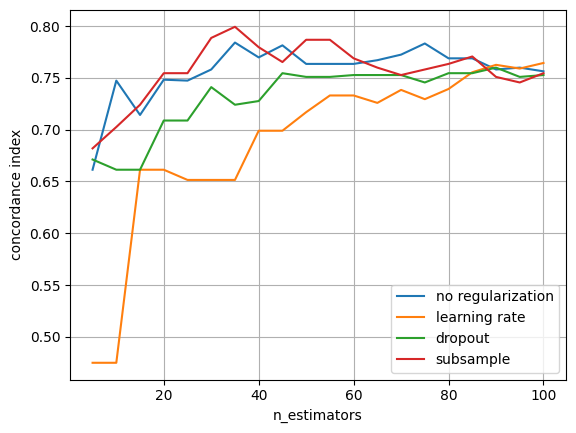

In [12]:
ax = scores_reg.plot(xlabel="n_estimators", ylabel="concordance index")
ax.grid(True)

The plot reveals that using dropout or a learning rate are most effective in avoiding overfitting. Moreover, the learning rate and ensemble size are strongly connected, choosing smaller a learning rate suggests increasing n_estimators. Therefore, it is recommended to use a relatively small learning rate and select the number of estimators via early stopping. Note that we can also apply multiple types of regularization, such as regularization by learning rate and subsampling. Since not all training data is used, this allows using the left-out data to evaluate whether we should continue adding more base learners or stop training.